### <div align='center'>Developing a Train/Test Split Scheme</div>

----

When developing a test set, our objective is to construct a collection of samples such that the relationships between all the features as well as the target are identical to the "real-world" samples that the model will estimate.

An overly simple formalization of this principle can be $  \hat{Y_{i \epsilon T}} \approx \hat{Y_{i \epsilon V}} $ where $T$ is the test set and $V$ is the set of real-world samples. Out of laziness it's my intention to only re-examine model performance on a monthly basis. Thus we can define $V$ as the set of all samples with recording dates from some day t, to t+30. and our objective becomes to identify a schema such that $ \hat{Y_{i \epsilon T}} \approx \hat{Y_{i \epsilon V}}$

In [1]:
from utils import *
ds, target = build_dataset()

In [2]:
import pandas as pd
df = pd.DataFrame(ds)
df[5] = df[5].apply(lambda x: str(x.year) + '_' + str(x.month))

In [3]:
df[11] = target

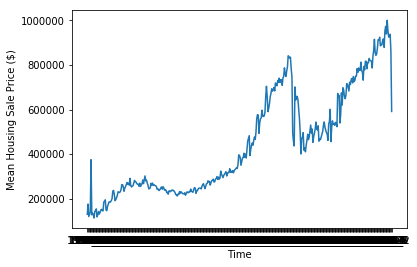

In [5]:
from matplotlib import pyplot as plt
plt.plot(df.groupby(5)[11].mean())
plt.xlabel('Time')
plt.ylabel('Mean Housing Sale Price ($)')
plt.show()

Based soley on this visualization, its clear that a random sampling from the dataset will produce a sub-optimal representation of $V$ for any given t. We can however make the assumption that this time series is a martingale i.e. that $ E(Y_{t}) = E(Y_{t+1}) $ making the optimal choice of $T$ the set of samples from the month prior. This will additionally help to mitigate the risk of any leakage in the dataset.

The question that remains is how to select our training set. Given the plot above, it seems possible that using every training sample may produce sub optimal results. Perhaps we could produce better models by selecting a fixed number of days prior to the start of our testing set, and using all samples within that range as the training set.... but what number of days produces the optimal result?

To answer this question, we can use our error metric on our test splits over different sized training sets on a model of our choice. We additionally want some evidence that this approach will generalize well into the future, thus we will examine the performance of all possible choices over a constant incriment for the last several years. FInally, given our dataset is often missing the last 3 months of data on any given day, our estimates for some date t, must only include training samples that are older than ninety days prior to t.

In [6]:
ds, target = build_dataset()
from datetime import datetime
from sklearn.ensemble import RandomForestRegressor
tp = {}
eval_date = datetime(year=2018, month=9, day=1)

for time_delt in range(1, 3650, 365):
    use_date = eval_date - timedelta(days=time_delt)
    test_err = []
    for dd in range(30, 1200, 30):
        train, test, train_target, test_target = build_t_filtered_datasets(use_date, dd, ds, target)
        rfr = RandomForestRegressor(n_estimators=20, max_depth=17, n_jobs=-1, min_samples_leaf=2, max_features='sqrt')
        rfr.fit(train, train_target)
        test_err.append(mean_log_err(test_target, rfr.predict(test)))
    tp[str(use_date)] = test_err

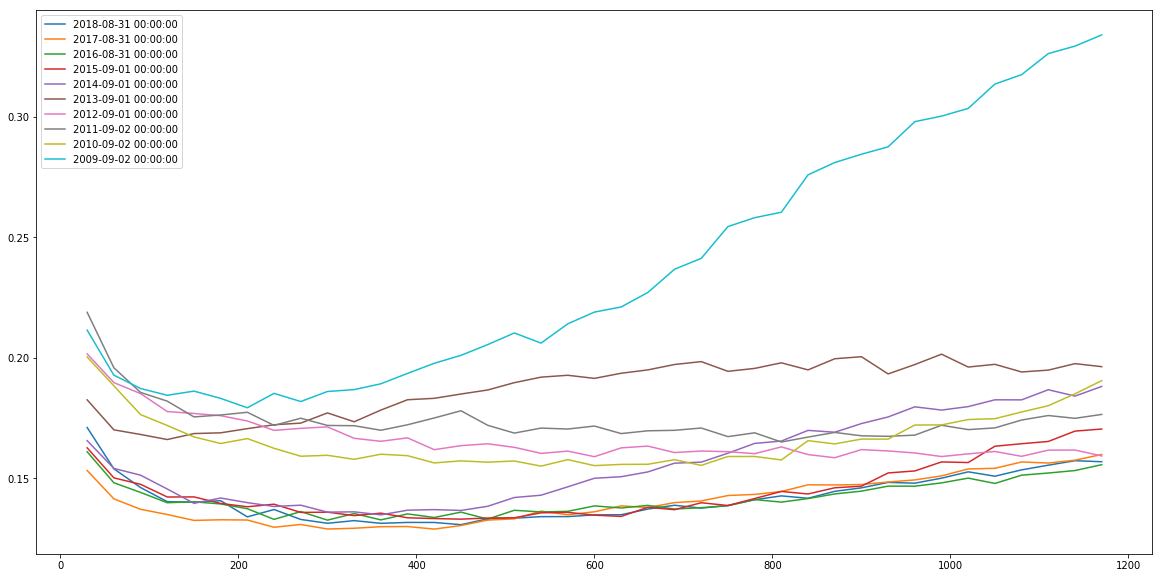

In [7]:
from matplotlib import pyplot as plt
legend = []
plt.figure(figsize=(20,10)) 
for key in tp:
    legend.append(key)
    plt.plot(range(30, 1200, 30), tp[key])
plt.legend(tp.keys())


It looks like the optimal choice over the last several years has been approx. 400 days. Thus our final split criteria will be for some given day t for which we want to generate an estimate, our training set  $E = \{(X_{i}, Y_{i}) | i \epsilon [t-490, t-90) \} $, $T = \{(X_{i}, Y_{i}) | i \epsilon [t, t+30) \} $